In [1]:
import numpy as np

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator

from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [3]:
# We define Pauli matices and a helper function for tensor products of Paulis for convenience to use later.
ident = np.array([[1, 0], [0, 1]])
pauli_x = np.array([[0, 1], [1, 0]])
pauli_y = np.array([[0, -1j], [1j, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

def pauli_product(pauli_string):
    """Helper method to compute kronecker product of Paulis"""

    prod = 1
    for p in pauli_string:
        if p == "I":
            prod = np.kron(prod, ident)
        elif p == "X":
            prod = np.kron(prod, pauli_x)
        elif p == "Y":
            prod = np.kron(prod, pauli_y)
        elif p == "Z":
            prod = np.kron(prod, pauli_z)

    return prod


## Decomposition of rotational gates via Solovay-Kitaev theorem

Here we want to quickly verify that the decomposition of a rotational gate with arbitrary angle into a sequence of discrete roations (S, H, T gates) in fact gives a approximation of that gate.

In [4]:
op_str = "SHTHTHTHTHTHTHTSHTHTHTHTSHTHTHTHTHTSHTSHTHTHTHTHTSHTHTHTSHTSHTHTSHTSHTSHTHTHTHTSHTHTHTHTHTSHTSHTHTSHTHTSHTSHTSHTSHTHTSHTSHTSHTSHTHTHTSHTSHTSHTHTHTHTSHTHTSHTHTHTSHTHTHTHTSHTHTSHTHTSHTSHTSHTHTHTHTHTHTHTSHTHTSHTHTHTSHTSHTHTHTSHTSHTSHTHTSHTHTHTHTSHTSHTSHSSS"

In [5]:
circ_ver = QuantumCircuit(1)
for s in op_str[::-1]:
    if s == "X":
        circ_ver.x(0)
    if s == "S":
        circ_ver.s(0)
    if s == "H":
        circ_ver.h(0)
    if s == "T":
        circ_ver.t(0)
op_ver = Operator(circ_ver).data * np.exp(1j * np.pi/4*7)
psi_ver = Statevector(circ_ver).data * np.exp(1j * np.pi/4*7)

In [6]:
circ = QuantumCircuit(1)
circ.rz(np.pi/128, 0)
op = Operator(circ).data
psi = Statevector(circ).data

In [7]:
print(f"psi = {psi}")
print(f"psi approx = {psi_ver}")
print(f"difference in psi = {psi - psi_ver}")
print(f"difference in op norm = {np.linalg.norm(op - op_ver)}")

psi = [0.9999247-0.01227154j 0.       +0.j        ]
psi approx = [ 9.99924702e-01-1.22715383e-02j -7.88544003e-11+1.97183987e-12j]
difference in psi = [6.83009205e-13+5.45335391e-11j 7.88544003e-11-1.97183987e-12j]
difference in op norm = 1.3561803846412896e-10


## Measuring in different bases

We have already seen that, in reality, we need to measure a circuit multiple times to obtain statistics for the measurement since we do not have access to the exact statevector. But we have not yes discussed how to measure operators. In principle, all operators can be expressed in the Pauli basis and so it all comes down to measuring $I, X, Y, Z$. However, our computational basis is the $Z$ eigenspace. To measure $X, Y$, we need to transform to the $Z$-eigenspace before measuring.

In [8]:
# initialize psi
circ = QuantumCircuit(1)
circ.rx(0.5, 0)
circ.draw()

┌─────────┐
q: ┤ Rx(0.5) ├
   └─────────┘

In [9]:
psi = Statevector(circ)
print(psi.data)
psi.draw('latex')

[0.96891242+0.j         0.        -0.24740396j]


<IPython.core.display.Latex object>

In [10]:
# measure X, Y, Z
val_x = np.real(np.conj(psi).dot(pauli_x).dot(psi))
val_y = np.real(np.conj(psi).dot(pauli_y).dot(psi))
val_z = np.real(np.conj(psi).dot(pauli_z).dot(psi))
print(f"<X> = {val_x}, <Y> = {val_y}, <Z> = {val_z}")

<X> = 0.0, <Y> = -0.479425538604203, <Z> = 0.8775825618903726


Now we want to do the same but measuring the circuit with individual shots. Let's start simply with measuring $Z$. We can simply append measurements since we are already in the computational basis.

In [11]:
circ.measure_all()


In [12]:
shots = 1000
result = AerSimulator().run(circuits=circ, shots=shots).result()
counts = result.get_counts()


{'1': 64, '0': 936}
0.936 0.064


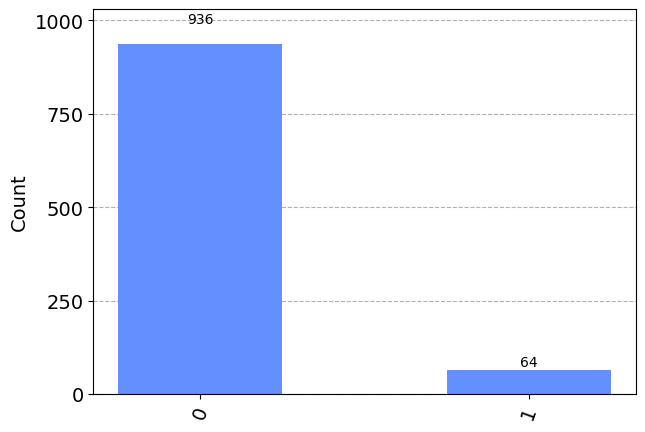

In [13]:
print(counts)
print(counts["0"]/shots, counts["1"]/shots)
plot_histogram(counts)


In [297]:
prob0 = counts["0"]/shots
prob1 = counts["1"]/shots

# When summing the probabilities, we need to account for the correct parities. See the lecture notes for details.
est_z = prob0 - prob1

In [303]:
print(f"exact <Z> value: {val_z}\nestimate of <Z> from shots: {est_z}")

exact <Z> value: 0.8775825618903726
estimate of <Z> from shots: 0.8799999999999999


To measure non-diagonal operators given only measurements in the diagonal (computational) basis, we need to transform to that basis before measurement.

In [304]:
# X-basis
circ_x = QuantumCircuit(1)
circ_x.rx(0.5, 0)
circ_x.barrier()
circ_x.h(0)
circ_x.measure_all()
print("circuit to measure in X")
print(circ_x.draw())

# Y-basis
circ_y = QuantumCircuit(1)
circ_y.rx(0.5, 0)
circ_y.barrier()
circ_y.rx(np.pi/2, 0)
circ_y.measure_all()
print("circuit to measure in Y")
print(circ_y.draw())

circuit to measure in X
        ┌─────────┐ ░ ┌───┐ ░ ┌─┐
     q: ┤ Rx(0.5) ├─░─┤ H ├─░─┤M├
        └─────────┘ ░ └───┘ ░ └╥┘
meas: 1/═══════════════════════╩═
                               0 
circuit to measure in Y
        ┌─────────┐ ░ ┌─────────┐ ░ ┌─┐
     q: ┤ Rx(0.5) ├─░─┤ Rx(π/2) ├─░─┤M├
        └─────────┘ ░ └─────────┘ ░ └╥┘
meas: 1/═════════════════════════════╩═
                                     0 


In [305]:
estimates = []
for circ in [circ_x, circ_y]:
    result = AerSimulator().run(circuits=circ, shots=shots).result()
    counts = result.get_counts()

    prob0 = counts["0"]/shots
    prob1 = counts["1"]/shots

    estimates.append(prob0 - prob1)

In [306]:
print(f"exact X value: {val_x}, estimate from shots: {estimates[0]}")
print(f"exact Y value: {val_y}, estimate from shots: {estimates[1]}")

exact X value: 0.0, estimate from shots: -0.07
exact Y value: -0.479425538604203, estimate from shots: -0.518


## Measuring multiple qubits

This carries over to measuring multiple qubits. However, we need to be more careful when summing the probabilities of measuring different operator values.

In [307]:
circ = QuantumCircuit(2)
circ.ry(0.4, 0)
circ.ry(2, 1)
print(circ.draw())

     ┌─────────┐
q_0: ┤ Ry(0.4) ├
     └┬───────┬┘
q_1: ─┤ Ry(2) ├─
      └───────┘ 


In [308]:
psi = Statevector(circ)
print(psi.data)
psi.draw('latex')


[0.52953223+0.j 0.1073415 +0.j 0.82469759+0.j 0.16717448+0.j]


<IPython.core.display.Latex object>

Measure $ZZ$ and $IX$

In [309]:
zz = pauli_product("ZZ")
xi = pauli_product("XI") # NOTE reverse order in qiskit
val_zz = np.real(np.conj(psi).dot(zz).dot(psi))
val_xi = np.real(np.conj(psi).dot(xi).dot(psi))

In [311]:
print(f"exact <ZZ> = {val_zz}")
print(f"exact <IX> = {val_xi}")

exact <ZZ> = -0.38329661892126715
exact <IX> = 0.9092974268256818


In [313]:
circ_zz = circ.copy()
circ_zz.measure_all()
print(circ_zz)

# rotate qubit 1 to X basis
circ_xi = circ.copy()
circ_xi.h(1)
circ_xi.measure_all()
print(circ_xi)

        ┌─────────┐ ░ ┌─┐   
   q_0: ┤ Ry(0.4) ├─░─┤M├───
        └┬───────┬┘ ░ └╥┘┌─┐
   q_1: ─┤ Ry(2) ├──░──╫─┤M├
         └───────┘  ░  ║ └╥┘
meas: 2/═══════════════╩══╩═
                       0  1 
        ┌─────────┐      ░ ┌─┐   
   q_0: ┤ Ry(0.4) ├──────░─┤M├───
        └┬───────┬┘┌───┐ ░ └╥┘┌─┐
   q_1: ─┤ Ry(2) ├─┤ H ├─░──╫─┤M├
         └───────┘ └───┘ ░  ║ └╥┘
meas: 2/════════════════════╩══╩═
                            0  1 


In [314]:
shots = 1000
result = AerSimulator().run(circuits=circ_zz, shots=shots).result()
counts = result.get_counts()

prob00 = counts.get("00", 0)/shots
prob01 = counts.get("01", 0)/shots
prob10 = counts.get("10", 0)/shots
prob11 = counts.get("11", 0)/shots

est_zz = prob00 - prob01 - prob10 + prob11


In [315]:
print(f"exact ZZ value: {val_zz}, estimate from shots: {est_zz}")

exact ZZ value: -0.38329661892126715, estimate from shots: -0.37600000000000006


In [316]:
shots = 1000
result = AerSimulator().run(circuits=circ_xi, shots=shots).result()
counts = result.get_counts()

prob00 = counts.get("00", 0)/shots
prob01 = counts.get("01", 0)/shots
prob10 = counts.get("10", 0)/shots
prob11 = counts.get("11", 0)/shots

est_xi = prob00 + prob01 - prob10 - prob11

In [317]:
print(f"exact XI value: {val_xi}, estimate from shots: {est_xi}")

exact XI value: 0.9092974268256818, estimate from shots: 0.896
